In [ ]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from models import GNet8_Encoder

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

accelerator = Accelerator(split_batches=False, mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']

print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)
print = accelerator.print # only print if local_rank=0

In [43]:
# Load embedding model
try:
    print(clip_img_embedder)
except:
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch="ViT-bigG-14",
        version="laion2b_s39b_b160k",
        output_tokens=True,
        only_tokens=True,
    )
    clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

In [45]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "sub-001_bs24_4gpu"
    all_recons_path = f"evals/{model_name}/{model_name}_all_enhancedrecons.pt"
    data_path = "/weka/proj-medarc/shared/mindeyev2_dataset"
    print("model_name:", model_name)

    jupyter_args = f"--model_name={model_name} --data_path={data_path} --all_recons_path={all_recons_path}"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: sub-001_bs24_4gpu
--model_name=sub-001_bs24_4gpu --data_path=/weka/proj-medarc/shared/mindeyev2_dataset --all_recons_path=evals/sub-001_bs24_4gpu/sub-001_bs24_4gpu_all_enhancedrecons.pt
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/weka/proj-fmri/shared/mindeyev2_dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--all_recons_path", type=str,
    help="Path to where all_recons.pt is stored",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

# Evals

In [48]:
all_images = torch.load(f"evals/{model_name}/{model_name}_all_images.pt")
all_clipvoxels = torch.load(f"evals/{model_name}/{model_name}_all_clipvoxels.pt")
all_predcaptions = torch.load(f"evals/{model_name}/{model_name}_all_predcaptions.pt")

print("all_recons_path:", all_recons_path)
all_recons = torch.load(all_recons_path)
all_unrefinedrecons = torch.load(f"evals/{model_name}/{model_name}_all_recons.pt")
# all_blurryrecons = torch.load(f"evals/{model_name}/{model_name}_all_blurryrecons.pt")

all_recons_path: evals/sub-001_bs24_4gpu/sub-001_bs24_4gpu_all_enhancedrecons.pt


In [49]:
model_name_plus_suffix = all_recons_path.split('/')[-1]
print(model_name_plus_suffix)
print(all_images.shape, all_recons.shape)

sub-001_bs24_4gpu_all_enhancedrecons.pt
torch.Size([150, 3, 256, 256]) torch.Size([150, 3, 512, 512])


In [1]:
# # create full grid of recon comparisons
# from PIL import Image

# imsize = 150
# if all_images.shape[-1] != imsize:
#     all_images = transforms.Resize((imsize,imsize))(all_images).float()
# if all_recons.shape[-1] != imsize:
#     all_recons = transforms.Resize((imsize,imsize))(all_recons).float()

# num_images = all_recons.shape[0]
# num_rows = (2 * num_images + 9) // 10

# # Interleave tensors
# merged = torch.stack([val for pair in zip(all_images, all_recons) for val in pair], dim=0)

# # Calculate grid size
# grid = torch.zeros((num_rows * 10, 3, all_recons.shape[-1], all_recons.shape[-1]))

# # Populate the grid
# grid[:2*num_images] = merged
# grid_images = [transforms.functional.to_pil_image(grid[i]) for i in range(num_rows * 10)]

# # Create the grid image
# grid_image = Image.new('RGB', (all_recons.shape[-1]*10, all_recons.shape[-1] * num_rows))  # 10 images wide

# # Paste images into the grid
# for i, img in enumerate(grid_images):
#     grid_image.paste(img, (all_recons.shape[-1] * (i % 10), all_recons.shape[-1] * (i // 10)))
# grid_image
# # grid_image.save(f"{model_name_plus_suffix[:-3]}_1000recons.png")

In [51]:
imsize = 256
if all_images.shape[-1] != imsize:
    all_images = transforms.Resize((imsize,imsize))(all_images).float()
if all_recons.shape[-1] != imsize:
    all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
try:
    if all_blurryrecons.shape[-1] != imsize:
        all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()
except:
    pass
    
if "enhanced" in model_name_plus_suffix:
    try:
        all_recons = all_recons*.75 + all_blurryrecons*.25
        print("weighted averaging to improve low-level evals")
    except:
        pass

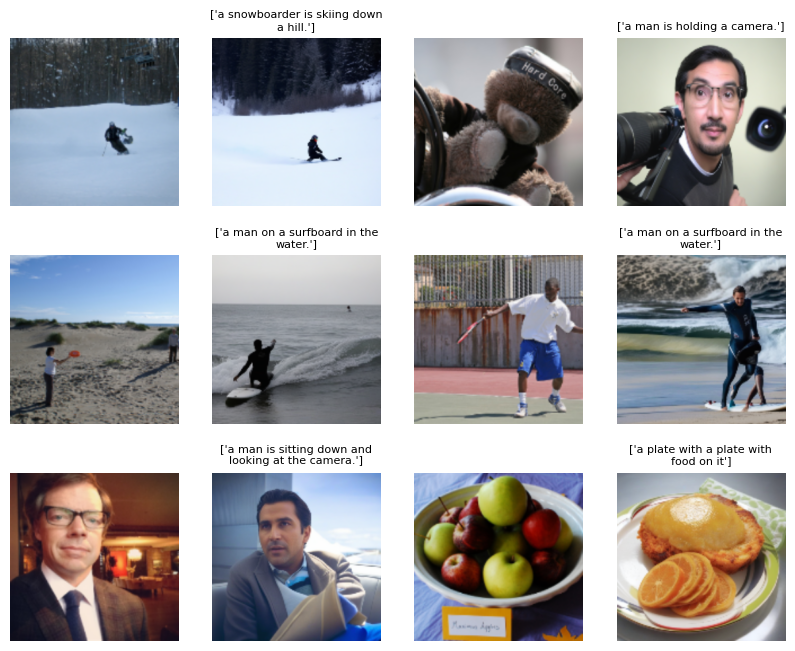

In [52]:
import textwrap
def wrap_title(title, wrap_width):
    return "\n".join(textwrap.wrap(title, wrap_width))

fig, axes = plt.subplots(3, 4, figsize=(10, 8))
jj=-1; kk=0;
for j in np.array([0,1,2,3,4,5]):
    jj+=1
    # print(kk,jj)
    axes[kk][jj].imshow(utils.torch_to_Image(all_images[j]))
    axes[kk][jj].axis('off')
    jj+=1
    axes[kk][jj].imshow(utils.torch_to_Image(all_recons[j]))
    axes[kk][jj].axis('off')
    axes[kk][jj].set_title(wrap_title(str(all_predcaptions[[j]]),wrap_width=30), fontsize=8)
    if jj==3: 
        kk+=1; jj=-1
plt.show()

# Retrieval eval (chance =  1/100)

In [53]:
from scipy import stats
percent_correct_fwds, percent_correct_bwds = [], []
percent_correct_fwd, percent_correct_bwd = None, None

with torch.cuda.amp.autocast(dtype=torch.float16):
    for test_i, loop in enumerate(tqdm(range(30))):
        random_samps = np.random.choice(np.arange(len(all_images)), size=100, replace=False)
        emb = clip_img_embedder(all_images[random_samps].to(device)).float() # CLIP-Image

        emb_ = all_clipvoxels[random_samps] # CLIP-Brain

        # flatten if necessary
        emb = emb.reshape(len(emb),-1).to(device)
        emb_ = emb_.reshape(len(emb_),-1).to(device)

        # l2norm 
        emb = nn.functional.normalize(emb,dim=-1)
        emb_ = nn.functional.normalize(emb_,dim=-1)

        labels = torch.arange(len(emb)).to(device)
        bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
        fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip

        assert len(bwd_sim) == 100

        percent_correct_fwds = np.append(percent_correct_fwds, utils.topk(fwd_sim, labels,k=1).item())
        percent_correct_bwds = np.append(percent_correct_bwds, utils.topk(bwd_sim, labels,k=1).item())

        if test_i==0:
            print("Loop 0:",percent_correct_fwds, percent_correct_bwds)
            
percent_correct_fwd = np.mean(percent_correct_fwds)
fwd_sd = np.std(percent_correct_fwds) / np.sqrt(len(percent_correct_fwds))
fwd_ci = stats.norm.interval(0.95, loc=percent_correct_fwd, scale=fwd_sd)

percent_correct_bwd = np.mean(percent_correct_bwds)
bwd_sd = np.std(percent_correct_bwds) / np.sqrt(len(percent_correct_bwds))
bwd_ci = stats.norm.interval(0.95, loc=percent_correct_bwd, scale=bwd_sd)

print(f"fwd percent_correct: {percent_correct_fwd:.4f} 95% CI: [{fwd_ci[0]:.4f},{fwd_ci[1]:.4f}]")
print(f"bwd percent_correct: {percent_correct_bwd:.4f} 95% CI: [{bwd_ci[0]:.4f},{bwd_ci[1]:.4f}]")

fwd_sim = np.array(fwd_sim.cpu())
bwd_sim = np.array(bwd_sim.cpu())

  3%|█▍                                          | 1/30 [00:00<00:09,  2.99it/s]

Loop 0: [0.94] [0.94999999]


100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.04it/s]

fwd percent_correct: 0.9537 95% CI: [0.9477,0.9596]
bwd percent_correct: 0.9307 95% CI: [0.9256,0.9357]


Given Brain embedding, find correct Image embedding


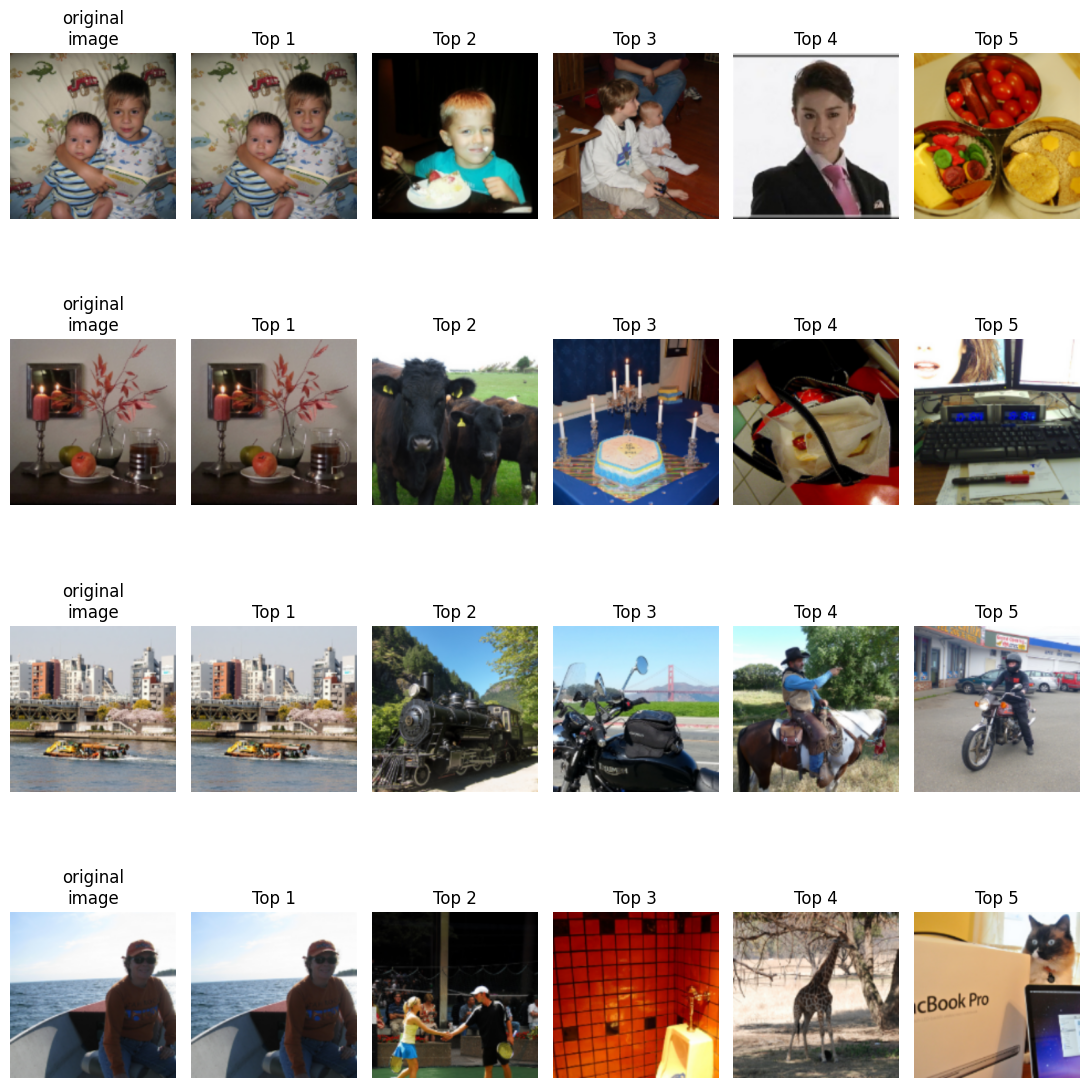

In [54]:
print("Given Brain embedding, find correct Image embedding")
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(all_images[random_samps][trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(all_images[random_samps][which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

## MST Paired Retrieval (chance = 50%)

In [55]:
if "MST" in model_name:
    MST_ID = np.load(f"evals/{model_name}/{model_name}_MST_ID.npy")
    pairs = utils.find_paired_indices(torch.Tensor(MST_ID))
    print(pairs)

In [56]:
if "MST" in model_name:
    binary_acc = []
    for i,(a,b) in enumerate(tqdm(pairs,total=len(pairs))):
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                emb_a = nn.functional.normalize(clip_img_embedder(all_images[[a]].to(device)).float().flatten(1),dim=-1)
                emb_b = nn.functional.normalize(clip_img_embedder(all_images[[b]].to(device)).float().flatten(1),dim=-1)
                emb_v = nn.functional.normalize(all_clipvoxels[[a]].flatten(1),dim=-1).to(device)
    
                a_sim = utils.pairwise_cosine_similarity(emb_v, emb_a).item()
                b_sim = utils.pairwise_cosine_similarity(emb_v, emb_b).item()
                
                binary_acc.append(a_sim > b_sim)
                
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                emb_a = nn.functional.normalize(clip_img_embedder(all_images[[a]].to(device)).float().flatten(1),dim=-1)
                emb_b = nn.functional.normalize(clip_img_embedder(all_images[[b]].to(device)).float().flatten(1),dim=-1)
                emb_v = nn.functional.normalize(all_clipvoxels[[b]].flatten(1),dim=-1).to(device)
    
                a_sim = utils.pairwise_cosine_similarity(emb_v, emb_a).item()
                b_sim = utils.pairwise_cosine_similarity(emb_v, emb_b).item()
                
                binary_acc.append(a_sim < b_sim)
                
    print(np.mean(binary_acc),np.std(binary_acc))

## 2-way identification

In [57]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

@torch.no_grad()
def two_way_identification(all_recons, all_images, model, preprocess, feature_layer=None, return_avg=True):
    preds = model(torch.stack([preprocess(recon) for recon in all_recons], dim=0).to(device))
    reals = model(torch.stack([preprocess(indiv) for indiv in all_images], dim=0).to(device))
    if feature_layer is None:
        preds = preds.float().flatten(1).cpu().numpy()
        reals = reals.float().flatten(1).cpu().numpy()
    else:
        preds = preds[feature_layer].float().flatten(1).cpu().numpy()
        reals = reals[feature_layer].float().flatten(1).cpu().numpy()

    r = np.corrcoef(reals, preds)
    r = r[:len(all_images), len(all_images):]
    congruents = np.diag(r)

    success = r < congruents
    success_cnt = np.sum(success, 0)

    if return_avg:
        perf = np.mean(success_cnt) / (len(all_images)-1)
        return perf
    else:
        return success_cnt, len(all_images)-1
    
all_recons=all_recons.to(device)
all_images=all_images.to(device)

## PixCorr

In [58]:
preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR),
])

# Flatten images while keeping the batch dimension
all_images_flattened = preprocess(all_images).reshape(len(all_images), -1).cpu()
all_recons_flattened = preprocess(all_recons).view(len(all_recons), -1).cpu()

print(all_images_flattened.shape)
print(all_recons_flattened.shape)

corr_stack = []

corrsum = 0
for i in tqdm(range(len(all_images))):
    corrcoef = np.corrcoef(all_images_flattened[i], all_recons_flattened[i])[0][1]
    if np.isnan(corrcoef):
        print("WARNING: CORRCOEF WAS NAN")
        corrcoef = 0
    corrsum += corrcoef
    corr_stack.append(corrcoef)
corrmean = corrsum / len(all_images)

pixcorr = corrmean
print(pixcorr)

torch.Size([150, 541875])
torch.Size([150, 541875])


100%|████████████████████████████████████████| 150/150 [00:00<00:00, 353.23it/s]

0.18866542817438245


## SSIM

In [59]:
# see https://github.com/zijin-gu/meshconv-decoding/issues/3
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR), 
])

# convert image to grayscale with rgb2grey
img_gray = rgb2gray(preprocess(all_images).permute((0,2,3,1)).cpu())
recon_gray = rgb2gray(preprocess(all_recons).permute((0,2,3,1)).cpu())
print("converted, now calculating ssim...")

ssim_score=[]
for im,rec in tqdm(zip(img_gray,recon_gray),total=len(all_images)):
    ssim_score.append(ssim(rec, im, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0))

ssim = np.mean(ssim_score)
print(ssim)

converted, now calculating ssim...


100%|████████████████████████████████████████| 150/150 [00:01<00:00, 114.88it/s]

0.42996208902743643


## AlexNet

In [60]:
from torchvision.models import alexnet, AlexNet_Weights
alex_weights = AlexNet_Weights.IMAGENET1K_V1

alex_model = create_feature_extractor(alexnet(weights=alex_weights), return_nodes=['features.4','features.11']).to(device)
alex_model.eval().requires_grad_(False).to(device)

# see alex_weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

layer = 'early, AlexNet(2)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_recons, all_images, 
                                                          alex_model, preprocess, 'features.4')
alexnet2 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet2:.4f}")

layer = 'mid, AlexNet(5)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_recons, all_images, 
                                                          alex_model, preprocess, 'features.11')
alexnet5 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet5:.4f}")


---early, AlexNet(2)---
2-way Percent Correct: 0.8868

---mid, AlexNet(5)---
2-way Percent Correct: 0.9221


## InceptionV3

In [61]:
from torchvision.models import inception_v3, Inception_V3_Weights
weights = Inception_V3_Weights.DEFAULT
inception_model = create_feature_extractor(inception_v3(weights=weights), 
                                           return_nodes=['avgpool']).to(device)
inception_model.eval().requires_grad_(False).to(device)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(342, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

all_per_correct = two_way_identification(all_recons, all_images,
                                        inception_model, preprocess, 'avgpool')
        
inception = np.mean(all_per_correct)
print(f"2-way Percent Correct: {inception:.4f}")

/admin/home-paulscotti/mindeye/lib/python3.11/site-packages/torchvision/models/feature_extraction.py:174: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


2-way Percent Correct: 0.8434


## CLIP

In [62]:
import clip
clip_model, preprocess = clip.load("ViT-L/14", device=device)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

all_per_correct = two_way_identification(all_recons, all_images,
                                        clip_model.encode_image, preprocess, None) # final layer
clip_ = np.mean(all_per_correct)
print(f"2-way Percent Correct: {clip_:.4f}")

2-way Percent Correct: 0.7950


## Efficient Net

In [63]:
import scipy as sp
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
weights = EfficientNet_B1_Weights.DEFAULT
eff_model = create_feature_extractor(efficientnet_b1(weights=weights), 
                                    return_nodes=['avgpool'])
eff_model.eval().requires_grad_(False).to(device)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(255, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = eff_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = eff_model(preprocess(all_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

effnet_nomean = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))])
effnet = effnet_nomean.mean()
print("Distance:",effnet)

Distance: 0.7557409947629398


## SwAV

In [64]:
swav_model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
swav_model = create_feature_extractor(swav_model, 
                                    return_nodes=['avgpool'])
swav_model.eval().requires_grad_(False).to(device)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = swav_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = swav_model(preprocess(all_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

swav_nomean = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))])
swav = swav_nomean.mean()
print("Distance:",swav)

Using cache found in /admin/home-paulscotti/.cache/torch/hub/facebookresearch_swav_main
/admin/home-paulscotti/mindeye/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/admin/home-paulscotti/mindeye/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Distance: 0.44739100376764934


In [65]:
#[pixcorr, ssim, alexnet2, alexnet5, inception, clip_, effnet, swav, percent_correct_fwd, percent_correct_bwd]
import pandas as pd
print(pd.DataFrame(["metrics", pixcorr, ssim, alexnet2, alexnet5, inception, clip_, effnet, swav, percent_correct_fwd, percent_correct_bwd, ]).to_string(index=False))
print(model_name_plus_suffix)

        0
  metrics
 0.188665
 0.429962
 0.886846
 0.922103
   0.8434
 0.794989
 0.755741
 0.447391
 0.953667
 0.930667
sub-001_bs24_4gpu_all_enhancedrecons.pt
